<a href="https://colab.research.google.com/github/rajagopalmotivate/DeepLearnIITMA1/blob/master/Generate_images_like_the_one_customer_likes_Color_CNN_VAE_with_Visualizer_LatentSize_v7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
`# This is formatted as code`
```

adjust latent dim to reduce reconstruction loss 

Generate images similar to 2 images that customer likes. 

Get the latent space of the the 2 images, and sample in that vicinity 

Find similar images 

Find image with common featutes

Image substraction and addition ..(add 2 images and subtract 1 in latent space to find new image)

Edit a video (drag slider to edit video in latent space)

Edit a multispectral image (3 channel or 7 channel image)

Real time audio denoising for cell phones

Multicondition

Cycle VAE (go from A to B using a encoderN/decoderM, then B to A using encoderM/decoderN. So eventually you are doing from A to A for the reconstruction loss that is across 2 vae combined). Hence given a image in A, this can generate a corresponding image in B. 


The VAE has a modular design. The encoder, decoder and VAE
are 3 models that share weights. After training the VAE model,
the encoder can be used to  generate latent vectors.
The decoder can be used to generate MNIST digits by sampling the
latent vector from a Gaussian distribution with mean=0 and std=1

In [1]:


from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist, fashion_mnist, cifar10
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.
    # Arguments:
        args (tensor): mean and log of variance of Q(z|X)
    # Returns:
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = 0 * K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon







Using TensorFlow backend.


In [0]:
def plot_results2(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    
   # os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, z = encoder.predict(x_test,
                                   batch_size=batch_size)
    
    print(z_mean[:, 0])
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c='r')

#    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
 #   plt.savefig(filename)
    plt.show()
    plt.scatter(z[:, 0], z[:, 1], c='g')
    plt.show()







In [0]:
def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as function of 2-dim latent vector
    # Arguments:
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
  #  plt.figure(figsize=(12, 10))
  #  plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test)
  #  plt.colorbar()
  #  plt.xlabel("z[0]")
  #  plt.ylabel("z[1]")
   # plt.savefig(filename)
   # plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 32
    figure = np.zeros((digit_size * n, digit_size * n, 3))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size, 3)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()

In [0]:
# MNIST dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

image_size = x_train.shape[1]
x_train = np.reshape(x_train, [-1, image_size, image_size, 3])
x_test = np.reshape(x_test, [-1, image_size, image_size, 3])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (image_size, image_size, 3)
batch_size = 128
kernel_size = 3
filters = 16
latent_dim = 1024
epochs = 30

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               activation='relu',
               strides=2,
               padding='same')(x)

# shape info needed to build decoder model
shape = K.int_shape(x)



In [0]:
# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)



In [0]:
# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])



In [7]:
# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 8, 8, 64)     18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 4096)         0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
dense_1 (D

In [8]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3], activation='relu')(latent_inputs)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        activation='relu',
                        strides=2,
                        padding='same')(x)
    filters //= 2

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)


decoderVisvalizer = Model(latent_inputs, x, name='decoderVisuvalizer')
plot_model(decoderVisvalizer, to_file='decoderVisuvalizer.png', show_shapes=True)




_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              4198400   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 32, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 32, 32, 3)         867       
Total params: 4,254,659
Trainable params: 4,254,659
Non-trainable params: 0
_________________________________________________________________


In [0]:
# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')



In [10]:
whatisthis = encoder(inputs)
print(whatisthis)

print(whatisthis[2])

[<tf.Tensor 'encoder/z_mean/BiasAdd:0' shape=(?, 1024) dtype=float32>, <tf.Tensor 'encoder/z_log_var/BiasAdd:0' shape=(?, 1024) dtype=float32>, <tf.Tensor 'encoder/z/add:0' shape=(?, 1024) dtype=float32>]
Tensor("encoder/z/add:0", shape=(?, 1024), dtype=float32)


In [11]:

models = (encoder, decoder)
data = (x_test, y_test)

typeoflossfun = True 
    # VAE loss = mse_loss or xent_loss + kl_loss
if typeoflossfun:
        reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))
else:
        reconstruction_loss = binary_crossentropy(K.flatten(inputs),
                                                  K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='rmsprop')
vae.summary()
    
plot_model(vae, to_file='vae_cnn.png', show_shapes=True)

        # train the autoencoder
vae.fit(x_train,
                epochs=2,
                batch_size=batch_size,
                validation_data=(x_test, None))
        
#vae.save_weights('vae_cnn_mnist.h5')



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 32, 32, 3)         0         
_________________________________________________________________
encoder (Model)              [(None, 1024), (None, 102 6313920   
_________________________________________________________________
decoder (Model)              (None, 32, 32, 3)         4254659   
Total params: 10,568,579
Trainable params: 10,568,579
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/2
50000/50000 [==============================] - 18s 364us/step - loss: 34.7262 - val_loss: 23.7036
Epoch 2/2
50000/50000 [==============================] - 16s 320us/step - loss: 20.2395 - val_loss: 16.6036


In [0]:
#additional training


In [0]:
from google.colab import files
files.download('vae_cnn_decoder.png')
files.download('vae_cnn_encoder.png')
files.download('vae_cnn.png')
files.download('decoderVisuvalizer.png')



In [16]:
vae.fit(x_train,
                epochs=5,
                batch_size=batch_size,
                validation_data=(x_test, None))

Train on 50000 samples, validate on 10000 samples
Epoch 1/5
50000/50000 [==============================] - 16s 325us/step - loss: 16.8714 - val_loss: 14.4058
Epoch 2/5
50000/50000 [==============================] - 16s 322us/step - loss: 15.1505 - val_loss: 14.3891
Epoch 3/5
50000/50000 [==============================] - 16s 321us/step - loss: 13.9485 - val_loss: 15.7464
Epoch 4/5
50000/50000 [==============================] - 16s 321us/step - loss: 12.9596 - val_loss: 14.5967
Epoch 5/5
50000/50000 [==============================] - 16s 321us/step - loss: 12.2141 - val_loss: 11.6540


In [17]:
vae.fit(x_train,
                epochs=10,
                batch_size=batch_size,
                validation_data=(x_test, None))

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 16s 324us/step - loss: 11.5813 - val_loss: 11.9624
Epoch 2/10
50000/50000 [==============================] - 16s 323us/step - loss: 11.0727 - val_loss: 11.9481
Epoch 3/10
50000/50000 [==============================] - 16s 321us/step - loss: 10.6728 - val_loss: 10.9427
Epoch 4/10
50000/50000 [==============================] - 16s 321us/step - loss: 10.2765 - val_loss: 10.3206
Epoch 5/10
50000/50000 [==============================] - 16s 321us/step - loss: 9.9029 - val_loss: 9.5929
Epoch 6/10
50000/50000 [==============================] - 16s 322us/step - loss: 9.6347 - val_loss: 10.2157
Epoch 7/10
50000/50000 [==============================] - 16s 322us/step - loss: 9.3403 - val_loss: 8.7224
Epoch 8/10
50000/50000 [==============================] - 16s 318us/step - loss: 9.0883 - val_loss: 9.1530
Epoch 9/10
50000/50000 [==============================] - 16s 318us/step - loss: 8.84

In [0]:
#plot_results(models, data, batch_size=batch_size, model_name="vae_cnn")

[ 0.02294509 -0.0028751   0.02781731 ...  0.02691717 -0.01721063
 -0.00985186]


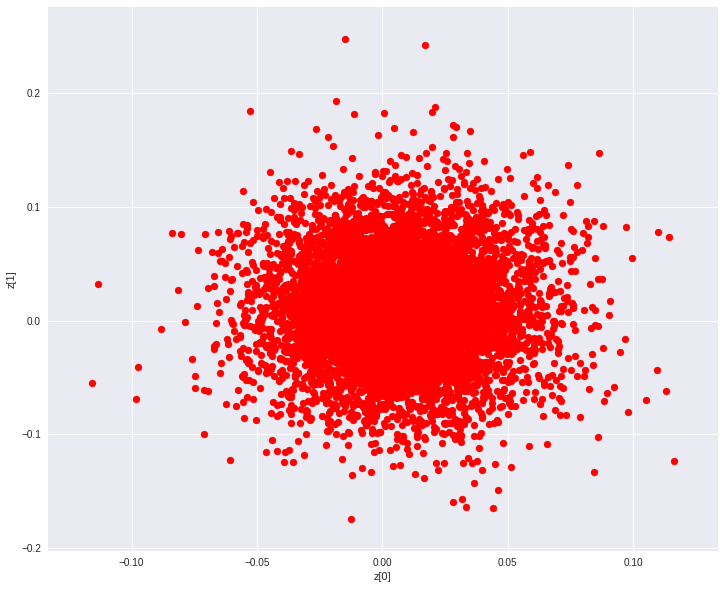

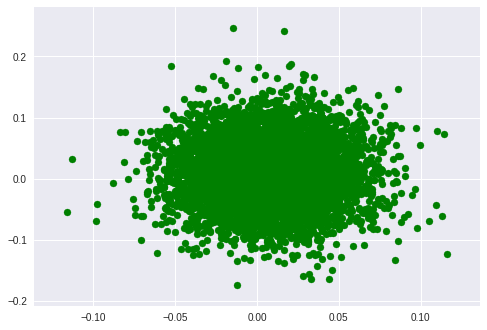

In [18]:
plot_results2(models, data, batch_size=batch_size, model_name="vae_cnn")

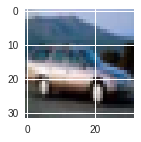

0
0
0
0
0
0
0
0
0
0
0
0


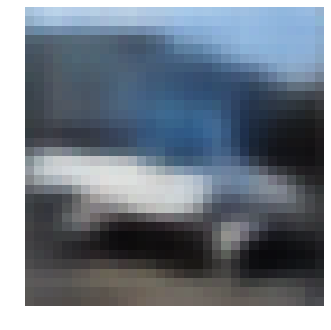

In [23]:
#@title 1. Select the image and find its latent vector. { run: "auto" }

sampleimage = "4" #@param ["1", "2", "3"] {allow-input: true}

imagenumber = int(sampleimage)

whatisthis = encoder.predict(x_train[0+imagenumber:1+imagenumber])

thislatentvector = whatisthis[2]

imagenumber = imagenumber
aimageset = x_train[0+imagenumber:1+imagenumber]
aimage = aimageset[0]

#print(aimage.shape)

plt.figure(figsize=(8, 2))
plt.imshow(aimage)
plt.show()

#print( whatisthis[2])

  

z_sample = thislatentvector

x_decoded = decoder.predict( [z_sample] )
digit = x_decoded[0].reshape(digit_size, digit_size, 3)

for i in range(12):
  print(int(round( thislatentvector[0][i]) ))

plt.axis('off')
plt.imshow(digit)
plt.show()

In [0]:
#@title
def createaimage(i1, i2, i3, i4 , i5, i6, i7, i8 , i9, i10, i11, i12):
  digit_size = 32


  plt.figure(figsize=(10, 4))
  for i in range(20):
      c = np_utils.to_categorical(0, 10)
    #  z_sample = np.random.rand(1, 2, 3, 4 , 1, 2 , 3, 4, 1, 1, 1, 1) # random 

      z_sample = np.array( [[-4, 0.1*i*10, 0, 0, 0, 0 ,0 ,0 ,0 ,0, 0, 0]] )
      z_sample = np.array( [[i1, i2, i3, i4, i5, i6, i7, i8, i9, i10, i11, i12]] )

    #  print(z_sample.shape)
    #  print(z_sample)
      c = c.reshape(1, 10)

      x_decoded = decoder.predict( [z_sample] )
      digit = x_decoded[0].reshape(digit_size, digit_size, 3)

      plt.subplot(1, 20, i+1)
      plt.axis('off')
      plt.imshow(digit)
  plt.show()

In [0]:
def createaimage(i1, i2, i3, i4 , i5, i6, i7, i8 , i9, i10, i11, i12):
  digit_size = 32


  plt.figure(figsize=(10, 10))
  for i in range(1):
      c = np_utils.to_categorical(0, 10)
    #  z_sample = np.random.rand(1, 2, 3, 4 , 1, 2 , 3, 4, 1, 1, 1, 1) # random 

      z_sample = np.array( [[-4, 0.1*i*10, 0, 0, 0, 0 ,0 ,0 ,0 ,0, 0, 0]] )
      z_sample = np.array( [[i1, i2, i3, i4, i5, i6, i7, i8, i9, i10, i11, i12]] )

    #  print(z_sample.shape)
    #  print(z_sample)
      c = c.reshape(1, 10)

      x_decoded = decoder.predict( [z_sample] )
      digit = x_decoded[0].reshape(digit_size, digit_size, 3)

      plt.subplot(1, 1, i+1)
      plt.axis('off')
      plt.imshow(digit)
  plt.show()

In [0]:
#@title 1. Select the image and find its latent vector. { run: "auto" }

sampleimage = "1" #@param ["1", "2", "3"] {allow-input: true}

imagenumber = int(sampleimage)

whatisthis = encoder.predict(x_train[0+imagenumber:1+imagenumber])

thislatentvector = whatisthis[2]

imagenumber = imagenumber
aimageset = x_train[0+imagenumber:1+imagenumber]
aimage = aimageset[0]

#print(aimage.shape)

plt.figure(figsize=(8, 2))
plt.imshow(aimage)
plt.show()

#print( whatisthis[2])

  
z_sample = np.array( [[i1, i2, i3, i4, i5, i6, i7, i8, i9, i10, i11, i12]] )

z_sample = thislatentvector

x_decoded = decoder.predict( [z_sample] )
digit = x_decoded[0].reshape(digit_size, digit_size, 3)

for i in range(12):
  print(int(round( thislatentvector[0][i]) ))

plt.axis('off')
plt.imshow(digit)
plt.show()

In [0]:
imagenumber = 1
aimageset = x_train[0+imagenumber:1+imagenumber]
aimage = aimageset[0]

#print(aimage.shape)

print(y_train[0+imagenumber])
plt.figure(figsize=(8, 2))
plt.imshow(aimage)
plt.show()







In [0]:
latentrepresentationofthisimage = encoder.predict(x_train[0+imagenumber:1+imagenumber])
thislatentvector = latentrepresentationofthisimage[2]

print(latentrepresentationofthisimage)


In [0]:
from keras.utils import np_utils
digit_size = 32


plt.figure(figsize=(10, 8))
for i in range(20):
    c = np_utils.to_categorical(0, 10)
    z_sample = np.random.rand(1, 2) # random 

    z_sample = np.array( [[-4, 0.1*i*10, 0, 0, 0, 0 ,0 ,0 ,0 ,0, 0, 0]] )
  #   print(z_sample.shape)
  #  print(z_sample)
    c = c.reshape(1, 10)

    x_decoded32 = decoderVisvalizer.predict( [z_sample] )
   # print(x_decoded32.shape)
   # print(x_decoded32.shape[3])
    noofchannels = x_decoded32.shape[3] 
    
        #say 32
    heightoftensor = x_decoded32.shape[1] 
    widthoftensor = x_decoded32.shape[2] 
    channelPplotcount = 0
    for channelP in range(0, 30, 3):
      x_decoded = np.copy(x_decoded32)
     # print(channelP)
      x_decoded = x_decoded[:,:,:, channelP:channelP+3]  
     # print(x_decoded.shape)
      digit = x_decoded[0].reshape(heightoftensor, widthoftensor, 3) 
      channelPplotcount = channelPplotcount + 1
      plt.subplot(10, 20, i*30/3  + channelPplotcount)
      plt.axis('off')
      plt.imshow(digit)
plt.show()